# Set up

In [1]:
import numpy as np
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

from pathlib import Path
import re
import pickle
import seaborn as sns

# Read&Edit Data

In [6]:
df = pd.read_csv("../PlotData/MVGP_21_result.csv")


def parse_list_safe(s):
    try:
        return ast.literal_eval(s)
    except Exception:
        return []

df["estimated_params_list"] = df["estimated_params"].apply(parse_list_safe)


params_df = df["estimated_params_list"].apply(pd.Series)


In [7]:
params_df.to_csv("Result/PE_result/PE_X_result.csv", index=False, header=False)

In [8]:
df = pd.read_csv("Result/MVGP_HCM_result.csv")

def parse_np_float_list(s):
    if pd.isna(s):
        return []
    s = str(s)

    s = re.sub(r'np\.float32\(', '', s)
    s = s.replace(')', '')

    try:
        out = ast.literal_eval(s)
    except Exception:
        out = re.findall(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', s)
    return [float(x) for x in out]


params_list = df["estimated_params"].apply(parse_np_float_list)
params_df = params_list.apply(pd.Series)


In [9]:
params_df.to_csv("Result/PE_result/PE_HCM_result.csv", index=False, header=False)

# Compare with the global version

In [2]:
X_test = pd.read_csv('../Data/X_test.csv', header=None, delimiter=',').values
# X_1_1 = pd.read_csv('X_1_1.csv', header=None, delimiter=',').values
# X_1_5 = pd.read_csv('X_1_5.csv', header=None, delimiter=',').values
# X_2 = pd.read_csv('X_2.csv', header=None, delimiter=',').values

PE_X_test = pd.read_csv('Result/PE_result//PE_X_result.csv', header=None, delimiter=',').values
# PE_X_1_1 = pd.read_csv('Result/PE_result/PE_X_1_1_result.csv', header=None, delimiter=',').values
# PE_X_1_5 = pd.read_csv('Result/PE_result/PE_X_1_5_result.csv', header=None, delimiter=',').values
# PE_X_2 = pd.read_csv('Result/PE_result/PE_X_2_result.csv', header=None, delimiter=',').values


X_MI_1_5 = pd.read_csv('X_MI_1_5.csv', header=None, delimiter=',').values
PE_X_MI_1 = pd.read_csv('Result/PE_result/PE_MI_1_result.csv', header=None, delimiter=',').values

X_MI_2 = pd.read_csv('X_MI_2.csv', header=None, delimiter=',').values
PE_X_MI_2 = pd.read_csv('Result/PE_result/PE_MI_2_result.csv', header=None, delimiter=',').values

X_MI_3 = pd.read_csv('X_MI_3.csv', header=None, delimiter=',').values
PE_X_MI_3 = pd.read_csv('Result/PE_result/PE_MI_3_result.csv', header=None, delimiter=',').values

X_HCM = pd.read_csv('X_HCM.csv', header=None, delimiter=',').values
PE_X_HCM = pd.read_csv('Result/PE_result/PE_HCM_result.csv', header=None, delimiter=',').values

In [ ]:
PE_X_test = pd.read_csv('Result/PE_result/PE_X_result.csv', header=None, delimiter=',').values

In [12]:
def rowwise_mse(A: np.ndarray, B: np.ndarray, name: str):

    if A.shape[0] != B.shape[0]:
        min_rows = min(A.shape[0], B.shape[0])
        print(f"warning: {name} row different, only use the first {min_rows} .")
        A = A[:min_rows,:]
        B = B[:min_rows,:]
    if A.shape[1] != B.shape[1]:
        min_cols = min(A.shape[1], B.shape[1])
        print(f"warning: {name} col different, only use the first {min_cols} .")
        A = A[:, :min_cols]
        B = B[:, :min_cols]

    return np.mean((B - A) ** 2, axis=1)


mse_test = rowwise_mse(X_test, PE_X_test, "X_test")
# mse_1_1  = rowwise_mse(X_1_1,  PE_X_1_1,  "X_1_1")
mse_1_5  = rowwise_mse(X_MI_1_5,  PE_X_MI_1,  "MI_1_5")
mse_2    = rowwise_mse(X_MI_2,    PE_X_MI_2,    "MI_2")
mse_3    = rowwise_mse(X_MI_3,    PE_X_MI_3,    "MI_3")
mse_hcm  = rowwise_mse(X_HCM,  PE_X_HCM,  "HCM")


print("Overall MSEs:",
      f"X_test={mse_test.mean():.6g},",
      f"MI_1_5={mse_1_5.mean():.6g},",
      f"MI_2={mse_2.mean():.6g}",
      f"MI_3={mse_3.mean():.6g}",
      f"HCM={mse_hcm.mean():.6g}")


Overall MSEs: X_test=0.00795599, MI_1_5=0.0203883, MI_2=0.01915 MI_3=0.0325478 HCM=0.0365534


C:\Users\r4718\AppData\Local\Temp\ipykernel_24704\3832612340.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mse_test, mse_1_5, mse_2, mse_3, mse_hcm], vert=True,


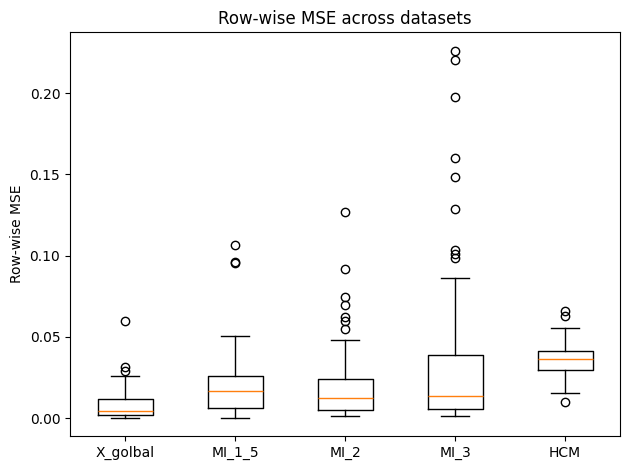

In [ ]:
plt.figure()
# plt.boxplot([mse_test, mse_1_1, mse_1_5, mse_2], vert=True,
#             labels=["X_global", "X_1_1", "X_1_5", "X_2"])
plt.boxplot([mse_test, mse_1_5, mse_2, mse_3, mse_hcm], vert=True,
            labels=["X_global", "MI_1_5", "MI_2", "MI_3", "HCM"])
plt.ylabel("Row-wise MSE")
plt.title("Row-wise MSE across datasets")
# plt.ylim(0, 0.01)
plt.tight_layout()
plt.show()

## PE for each P in different G

In [5]:
def to_numpy(a):
    """Support numpy / torch tensor / pandas."""
    if hasattr(a, "detach"):  # torch tensor
        return a.detach().cpu().numpy()
    if hasattr(a, "to_numpy"):  # pandas
        return a.to_numpy()
    return np.asarray(a)

def plot_group_param_mse_boxplot(X_test, PE_X_test, group_size=20):
    X = to_numpy(X_test)
    PE = to_numpy(PE_X_test)

    # ---- basic checks ----
    if X.shape != PE.shape:
        raise ValueError(f"Shape mismatch: X {X.shape} vs PE {PE.shape}")
    if X.ndim != 2 or X.shape[1] != 10:
        raise ValueError(f"Expected shape (N,10). Got {X.shape}")
    if X.shape[0] % group_size != 0:
        raise ValueError(f"N={X.shape[0]} not divisible by group_size={group_size}")

    n_groups = X.shape[0] // group_size
    if n_groups != 5:
        print(f"Warning: inferred n_groups={n_groups} (expected 5 from your description). Proceeding anyway.")

    # squared error per sample per parameter
    se = (PE - X) ** 2  # shape (N,10)

    box_data = []   # each element: array of length group_size (SE distribution)
    labels = []
    mse_table = []  # (group, param_idx, mse)

    # group g uses params (2g, 2g+1): i.e., (0,1), (2,3), (4,5), (6,7), (8,9)
    for g in range(n_groups):
        r0, r1 = g * group_size, (g + 1) * group_size
        cols = [2*g, 2*g + 1]
        for c in cols:
            vals = se[r0:r1, c]                 # length=group_size
            box_data.append(vals)
            labels.append(f"G{g+1}-P{c+1}")      # P uses 1-based indexing for readability
            mse_table.append((g+1, c+1, float(vals.mean())))

    # ---- plot ----
    plt.figure(figsize=(12, 5))
    plt.boxplot(
        box_data,
        labels=labels,
        showmeans=True,
        meanline=False
    )
    plt.ylabel("Squared Error (per-sample)")
    plt.title("Per-group parameter error distribution (boxes) and MSE (means)")

    # group separators (after every 2 boxes)
    for k in range(1, n_groups):
        plt.axvline(x=2*k + 0.5, linewidth=1)

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


    return mse_table

# ===== Usage =====
# mse_table = plot_group_param_mse_boxplot(X_test, PE_X_test, group_size=20)


C:\Users\r4718\AppData\Local\Temp\ipykernel_26268\3157721516.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


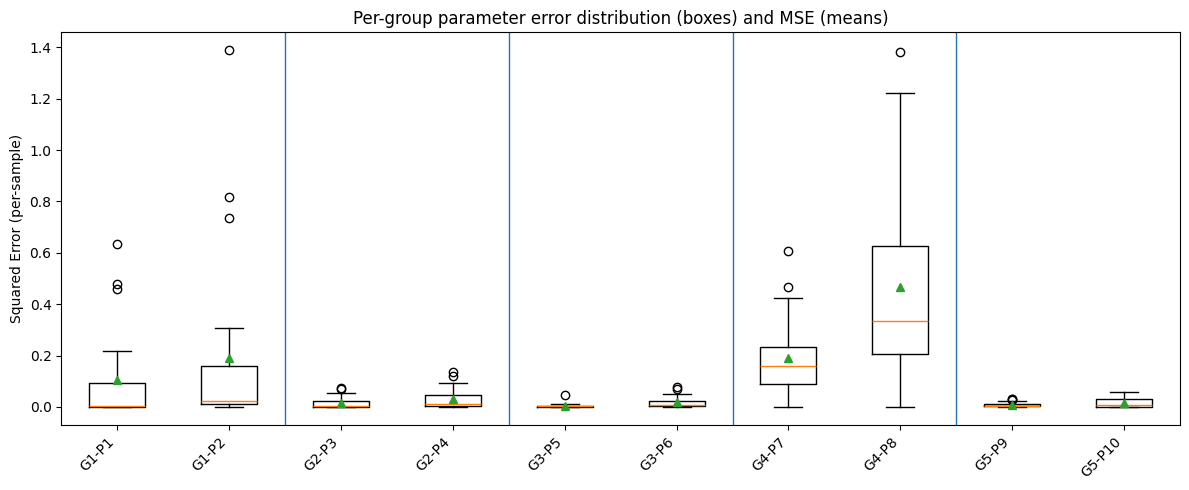

[(1, 1, 0.10331368026800702),
 (1, 2, 0.19162955328049847),
 (2, 3, 0.016545522521335503),
 (2, 4, 0.03165398708495454),
 (3, 5, 0.005249400084105995),
 (3, 6, 0.017578906572785005),
 (4, 7, 0.18989554619607804),
 (4, 8, 0.4669111514454641),
 (5, 9, 0.008819881981686001),
 (5, 10, 0.017199962866745487)]

In [6]:
plot_group_param_mse_boxplot(X_MI_3, PE_X_MI_3, group_size=20)

C:\Users\r4718\AppData\Local\Temp\ipykernel_24704\3969866584.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(regions, vert=True, labels=labels)


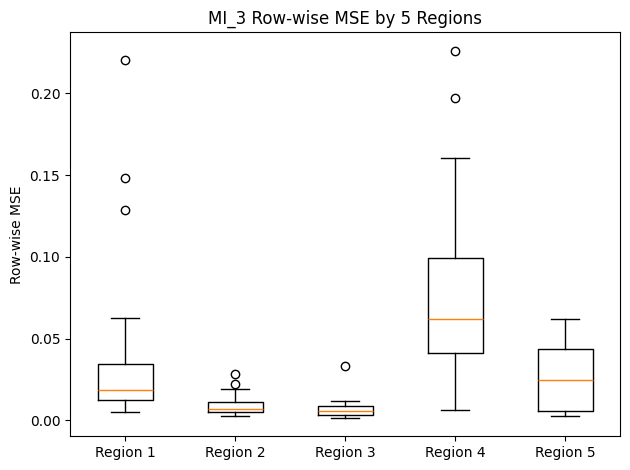

In [22]:
region_size = 20
regions = []
labels = []
for i in range(5):
    start = i * region_size
    end   = (i + 1) * region_size
    regions.append(mse_3[start:end])
    labels.append(f"Region {i+1}")


plt.figure()
plt.boxplot(regions, vert=True, labels=labels)
plt.ylabel("Row-wise MSE")
plt.title("MI_3 Row-wise MSE by 5 Regions")
plt.tight_layout()
plt.show()

In [10]:
def plot_region_mse_boxplot(X_test, PE_X_test):
    X = to_numpy(X_test)
    PE = to_numpy(PE_X_test)

    if X.shape != PE.shape:
        raise ValueError(f"Shape mismatch: X {X.shape} vs PE {PE.shape}")
    if X.ndim != 2 or X.shape[1] != 10:
        raise ValueError(f"Expected shape (N,10). Got {X.shape}")

    se = (PE - X) ** 2  # (N,10)

    n_regions = X.shape[1] // 2  # 5
    box_data = []
    labels = []
    mse_summary = []

    for r in range(n_regions):
        c0, c1 = 2*r, 2*r + 1
        # per-sample region MSE: mean over the 2 columns
        region_mse_per_sample = se[:, [c0, c1]].mean(axis=1)  # (N,)
        box_data.append(region_mse_per_sample)
        labels.append(f"Region{r+1} (P{c0+1},P{c1+1})")
        mse_summary.append(region_mse_per_sample.mean())

    # boxplot over samples
    plt.figure(figsize=(10, 5))
    plt.boxplot(box_data, labels=labels, showmeans=True)
    plt.ylabel("Region-wise MSE per sample (mean of 2 params' squared errors)")
    plt.title("Region-wise MSE distribution across samples")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    # print overall MSE per region
    print("Overall MSE per Region (mean over all samples):")
    for i, v in enumerate(mse_summary, 1):
        print(f"  Region{i}: {v:.6g}")

    return mse_summary

C:\Users\r4718\AppData\Local\Temp\ipykernel_26268\3777731936.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels, showmeans=True)


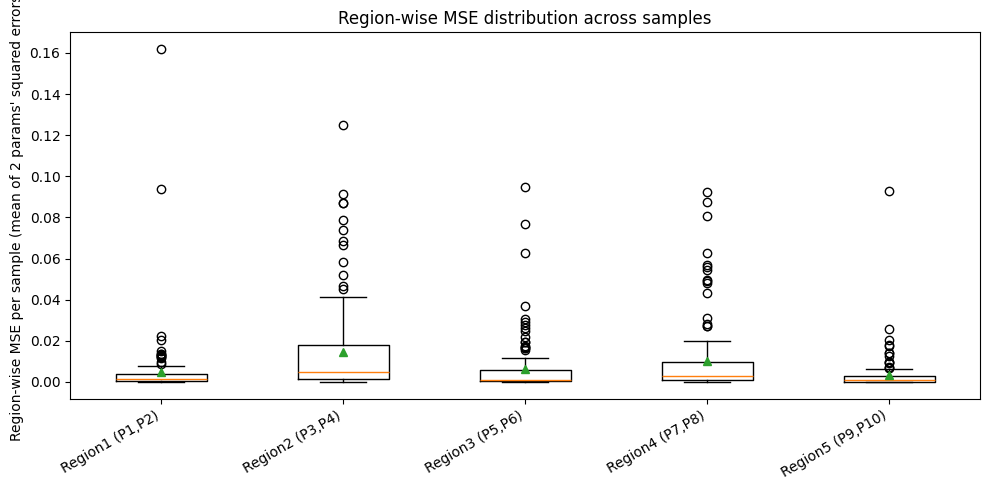

Overall MSE per Region (mean over all samples):
  Region1: 0.00502885
  Region2: 0.014733
  Region3: 0.00642813
  Region4: 0.0103165
  Region5: 0.00327349


[np.float64(0.005028849764494545),
 np.float64(0.014732974379588837),
 np.float64(0.006428134329491469),
 np.float64(0.010316516185093213),
 np.float64(0.0032734918906313845)]

In [11]:
plot_region_mse_boxplot(X_test, PE_X_test)

# KNN Dist

In [6]:
from sklearn.neighbors import NearestNeighbors

# X_train = pd.read_csv("../Data/X_train.csv").values
X_train = pd.read_csv('../Data/Data20260110/X_train_Final_10.csv', header=None, delimiter=',').values
# X_train = X_train[:4096, :]
X_test = pd.read_csv('../Data/Data20260110/X_test.csv', header=None, delimiter=',').values
X_MI_1_5   = pd.read_csv("X_MI_1_5.csv").values
X_MI_2     = pd.read_csv("X_MI_2.csv").values
X_MI_3 = pd.read_csv("X_MI_3.csv").values
X_HCM = pd.read_csv("X_HCM.csv").values



k = 100
nn = NearestNeighbors(n_neighbors=k, metric="euclidean", algorithm="auto")
nn.fit(X_train)

def mean_knn_dist(X_query, model, k):

    distances, indices = model.kneighbors(X_query, n_neighbors=k, return_distance=True)
    mean_dist = distances.mean(axis=1)
    return mean_dist


mean_dist_test = mean_knn_dist(X_test, nn, k)

mean_dist_MI_1_5 = mean_knn_dist(X_MI_1_5, nn, k)
mean_dist_MI_2 = mean_knn_dist(X_MI_2, nn, k)
mean_dist_MI_3 = mean_knn_dist(X_MI_3, nn, k)

mean_dist_HCM = mean_knn_dist(X_HCM, nn, k)



C:\Users\r4718\AppData\Local\Temp\ipykernel_14360\1637186909.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


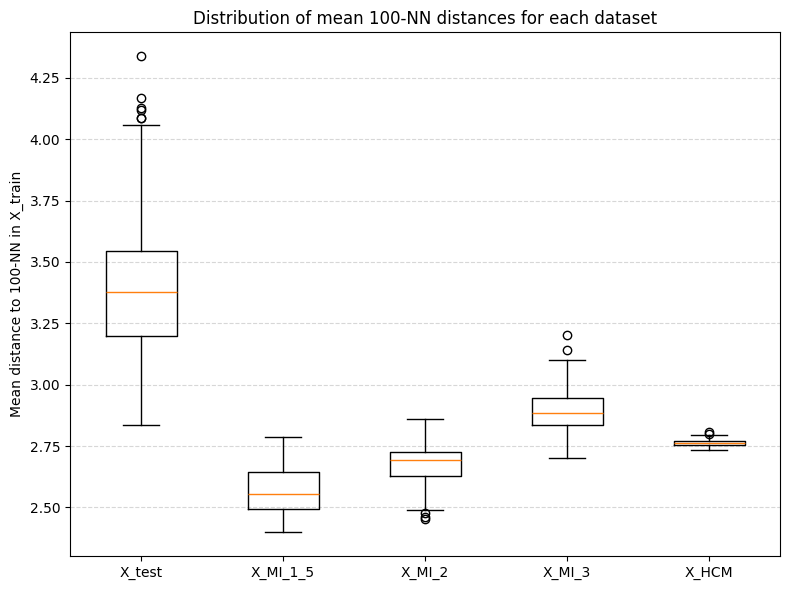

In [7]:
import matplotlib.pyplot as plt


data = [mean_dist_test, mean_dist_MI_1_5, mean_dist_MI_2, mean_dist_MI_3, mean_dist_HCM]
labels = ["X_test", "X_MI_1_5", "X_MI_2", "X_MI_3", "X_HCM"]

plt.figure(figsize=(8, 6))
plt.boxplot(
    data,
    labels=labels,

)

plt.ylabel("Mean distance to 100-NN in X_train")
plt.title("Distribution of mean 100-NN distances for each dataset")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Overall strain BaseLine

In [4]:

SEGMENTS_FILE_ORDER_16 = [
    "Basal-InfSept","Basal-AntSept","Basal-Ant","Basal-AntLat","Basal-InfLat","Basal-Inf",
    "Mid-InfSept","Mid-AntSept","Mid-Ant","Mid-AntLat","Mid-InfLat","Mid-Inf",
    "Apical-Septal","Apical-Anterior","Apical-Lateral","Apical-Inferior",
]
APEX_NAME = "Apex"



# 2) circ/rad/longi -> overall strain

def overall_strain(ecc, err, ell, method="signed_vm"):
    """
    ecc: circumferential strain
    err: radial strain
    ell: longitudinal strain

    method:
      - "vm": von Mises 等效应变（非负）
      - "signed_vm": 推荐：用 sign(ecc+ell) 给 von Mises 加符号
      - "cl_rss": 只合并 circ+longi 的幅值（signed）
      - "rss": sqrt(ecc^2+err^2+ell^2)（非负）
      - "mean": (ecc+err+ell)/3
    """
    ecc, err, ell = float(ecc), float(err), float(ell)

    if method in ("vm", "signed_vm"):
        em = (ecc + err + ell) / 3.0
        evm = np.sqrt((2.0/3.0) * ((ecc-em)**2 + (err-em)**2 + (ell-em)**2))
        if method == "vm":
            return evm
        sgn = np.sign(ecc + ell) if (ecc + ell) != 0 else 0.0
        return sgn * evm

    if method == "cl_rss":
        mag = np.sqrt(ecc**2 + ell**2)
        sgn = np.sign(ecc + ell) if (ecc + ell) != 0 else 0.0
        return sgn * mag

    if method == "rss":
        return np.sqrt(ecc**2 + err**2 + ell**2)

    if method == "mean":
        return (ecc + err + ell) / 3.0

    raise ValueError(f"Unknown method: {method}")



def load_strain_table(path):
    """
    dir1=circ, dir2=rad, dir3=longi
    """
    df_raw = pd.read_csv(path, sep=r"\s+", header=None)
    ncols = df_raw.shape[1]

    if ncols == 1 + 3*17:
        segments = SEGMENTS_FILE_ORDER_16 + [APEX_NAME]
    elif ncols == 1 + 3*16:
        segments = SEGMENTS_FILE_ORDER_16[:]
    else:
        raise ValueError(f"列数不匹配：期望 49 或 52，实际 {ncols}")

    cols = ["LV_volume"]
    for d in range(1, 4):
        cols += [f"{seg}__dir{d}" for seg in segments]
    df_raw.columns = cols


    if APEX_NAME not in segments:
        for d in range(1, 4):
            df_raw[f"{APEX_NAME}__dir{d}"] = np.nan
        segments = segments + [APEX_NAME]

    return df_raw, segments



def build_overall_values_for_row(df, segments, row_idx, method="signed_vm"):
    """
    dir1=circ, dir2=rad, dir3=longi

    """
    values = {}
    for seg in segments:
        ecc = df.loc[row_idx, f"{seg}__dir1"]  # circ
        err = df.loc[row_idx, f"{seg}__dir2"]  # rad
        ell = df.loc[row_idx, f"{seg}__dir3"]  # longi
        values[seg] = overall_strain(ecc, err, ell, method=method)
    return values


def global_vmin_vmax(df, segments, method="signed_vm"):
    allv = []
    for i in range(len(df)):
        vals = build_overall_values_for_row(df, segments, i, method=method)
        allv.extend([v for v in vals.values() if np.isfinite(v)])
    allv = np.array(allv, dtype=float)
    return float(np.min(allv)), float(np.max(allv))



def plot_bullseye(values_by_name,
                  title="",
                  basal_mid_start_deg=240.0,
                  apical_start_deg=225.0,
                  vmin=None, vmax=None,
                  symmetric_scale=False,
                  show_labels=True,
                  show_apex_label=False,
                  cmap="viridis"):


    basal_order  = ["Basal-InfSept","Basal-AntSept","Basal-Ant","Basal-AntLat","Basal-InfLat","Basal-Inf"]
    mid_order    = ["Mid-InfSept","Mid-AntSept","Mid-Ant","Mid-AntLat","Mid-InfLat","Mid-Inf"]
    apical_order = ["Apical-Septal","Apical-Anterior","Apical-Lateral","Apical-Inferior"]

    rings = [
        ("Basal",  basal_order,  (2.0, 1.0), 60.0, basal_mid_start_deg),
        ("Mid",    mid_order,    (1.0, 1.0), 60.0, basal_mid_start_deg),
        ("Apical", apical_order, (0.5, 0.5), 90.0, apical_start_deg),
        ("Apex",   [APEX_NAME],  (0.0, 0.5), 360.0, 0.0),
    ]

    vals = np.array([v for v in values_by_name.values() if np.isfinite(v)], dtype=float)
    if vals.size == 0:
        raise ValueError("没有可绘制的数值")

    if vmin is None: vmin = float(np.min(vals))
    if vmax is None: vmax = float(np.max(vals))
    if symmetric_scale:
        m = max(abs(vmin), abs(vmax))
        vmin, vmax = -m, m
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, projection="polar")

    ax.set_theta_direction(-1)   # 顺时针
    ax.set_theta_offset(0.0)    # 0°在右
    ax.set_ylim(0, 3.0)
    ax.set_xticks([]); ax.set_yticks([]); ax.grid(False)

    for ring_name, seg_names, (bottom, thickness), width_deg, start_deg in rings:
        if ring_name == "Apex":
            val = values_by_name.get(APEX_NAME, np.nan)
            if np.isfinite(val):
                # 中心整圆：不画边线（无分割线）
                ax.bar(
                    np.deg2rad(0.0), thickness, width=2*np.pi, bottom=bottom, align="edge",
                    linewidth=0.0, edgecolor="none",
                    color=plt.get_cmap(cmap)(norm(val))
                )
                if show_apex_label and show_labels:
                    ax.text(0, bottom + thickness/2, "Apex", ha="center", va="center", fontsize=9)
            continue

        width = np.deg2rad(width_deg)
        for i, nm in enumerate(seg_names):
            val = values_by_name.get(nm, np.nan)
            if not np.isfinite(val):
                continue

            seg_start_deg = start_deg - i * width_deg
            theta0 = np.deg2rad(-seg_start_deg)  # 取负号：确保显示角度=seg_start_deg

            ax.bar(
                theta0, thickness, width=width, bottom=bottom, align="edge",
                linewidth=1.0, edgecolor="white",
                color=plt.get_cmap(cmap)(norm(val))
            )

            if show_labels:
                theta_mid = theta0 + width/2
                r_mid = bottom + thickness/2
                short = (nm.replace("Basal-", "B ")
                           .replace("Mid-", "M ")
                           .replace("Apical-", "A "))
                ax.text(theta_mid, r_mid, short, ha="center", va="center", fontsize=9)

    ax.set_title(title, va="bottom", fontsize=12)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.08, fraction=0.045)
    cbar.set_label("Overall strain")

    plt.show()






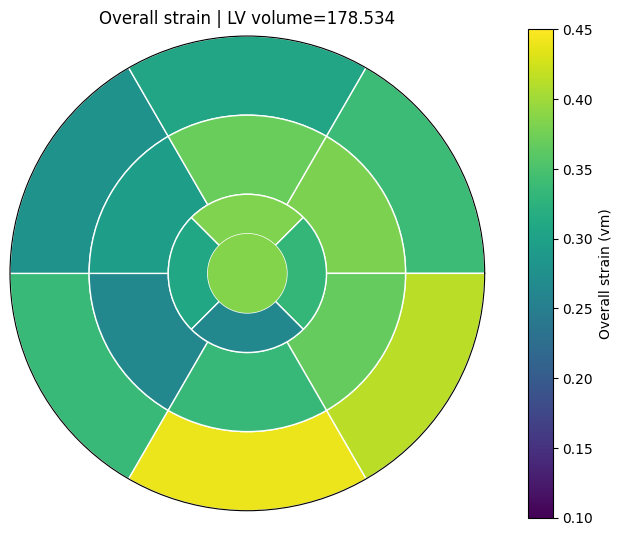

In [12]:
if __name__ == "__main__":
    path = "simulation_results_BL.txt"  
    df, segments = load_strain_table(path)

    row_idx = 0
    method = "vm"      # signed_vm； vm / cl_rss / rss / mean
    show_labels = False
    show_apex_label = False   


    use_global_scale = False
    symmetric_scale = False

    values = build_overall_values_for_row(df, segments, row_idx, method=method)
    vol = float(df.loc[row_idx, "LV_volume"])

    if use_global_scale:
        vmin, vmax = global_vmin_vmax(df, segments, method=method)
    else:
        vmin, vmax = None, None

    plot_bullseye(
        values,
        title=f"Overall strain | LV volume={vol:.3f}",
        basal_mid_start_deg=240.0,  # Basal/Mid：240°开始
        apical_start_deg=225.0,     # Apical：225°开始（你的新要求）
        # vmin=vmin, vmax=vmax,
        vmin=0.1, vmax=0.45,
        symmetric_scale=symmetric_scale,
        show_labels=show_labels,
        show_apex_label=show_apex_label,
        cmap="viridis"
    )

## MI_1.5

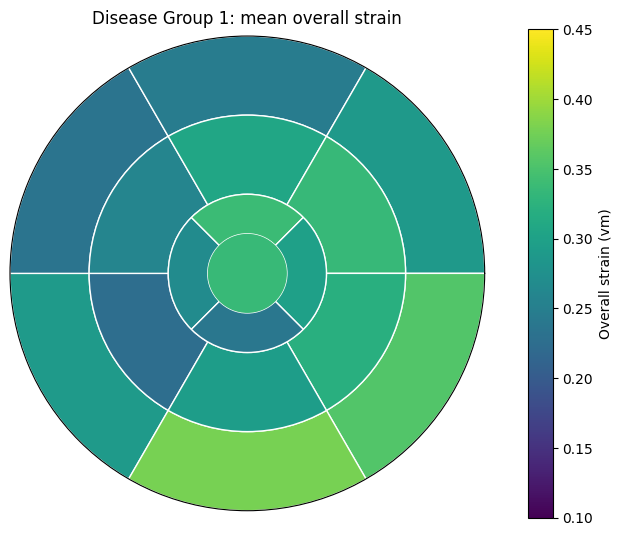

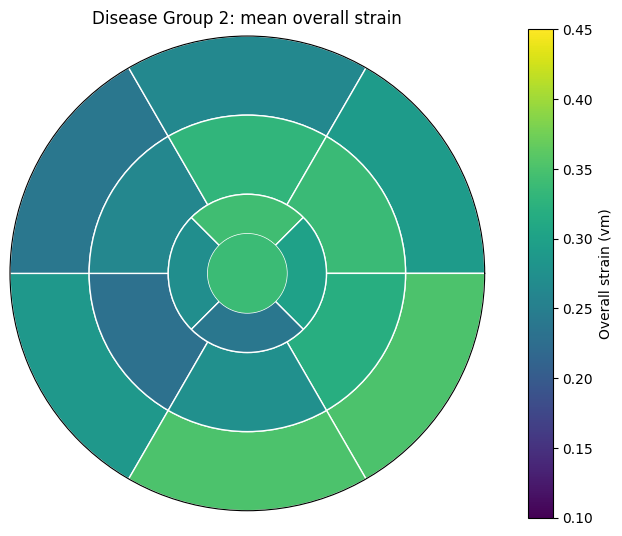

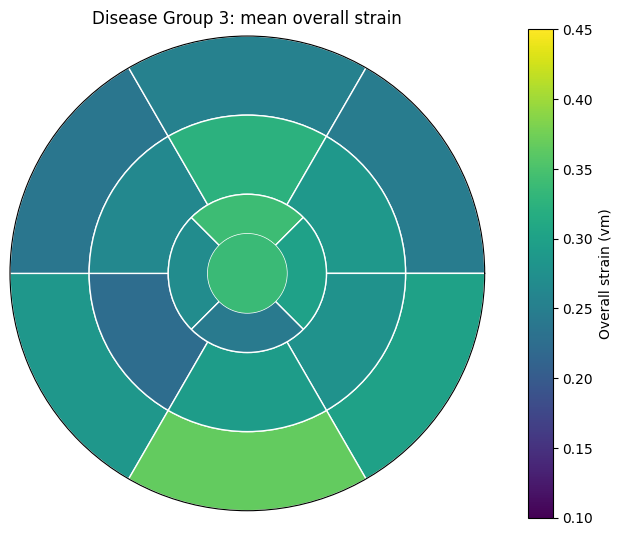

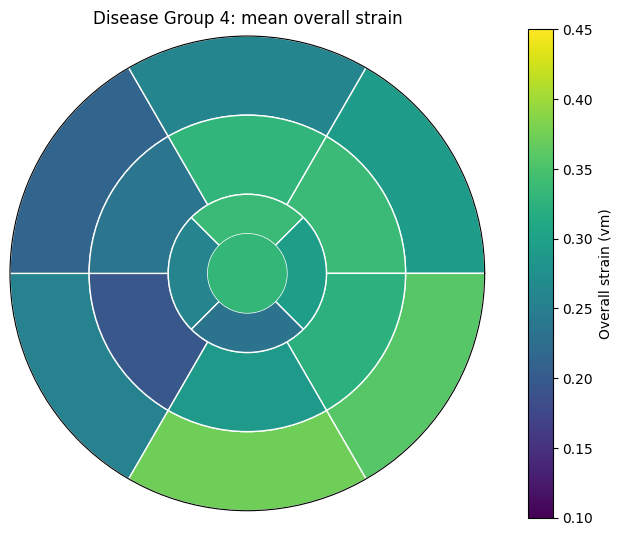

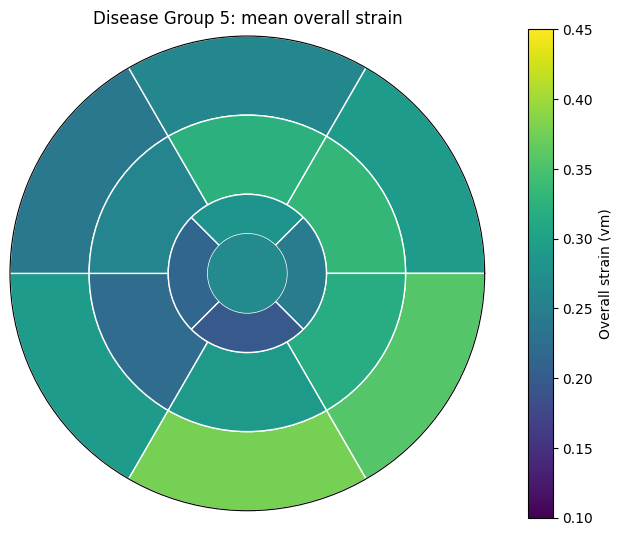

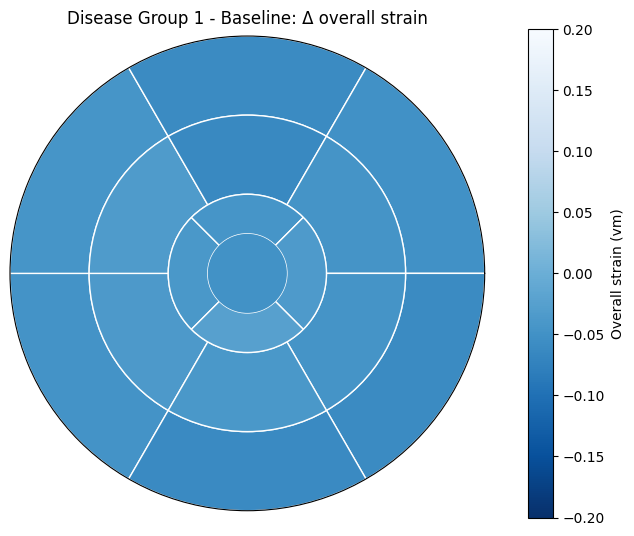

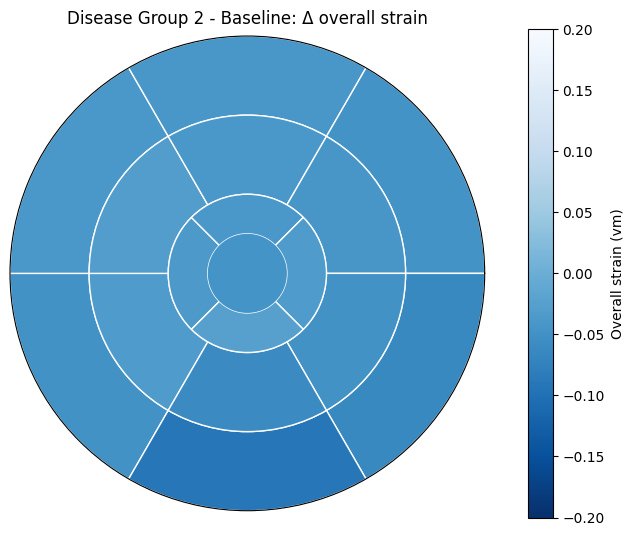

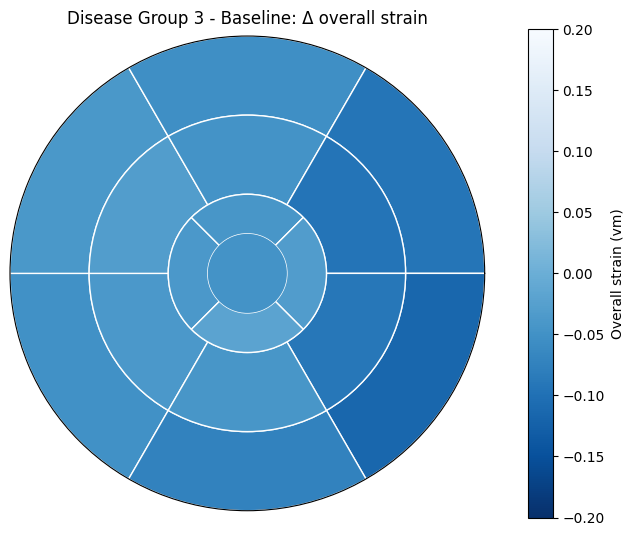

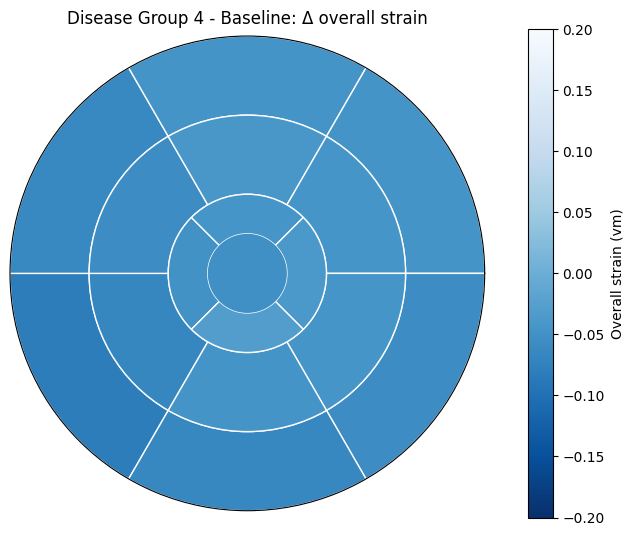

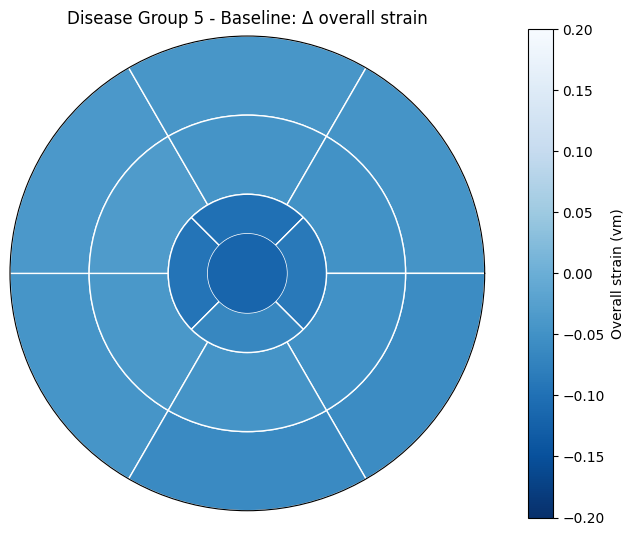

In [17]:
SEGMENTS_16 = [
    "Basal-InfSept","Basal-AntSept","Basal-Ant","Basal-AntLat","Basal-InfLat","Basal-Inf",
    "Mid-InfSept","Mid-AntSept","Mid-Ant","Mid-AntLat","Mid-InfLat","Mid-Inf",
    "Apical-Septal","Apical-Anterior","Apical-Lateral","Apical-Inferior",
]
APEX = "Apex"

def load_strain_table(path: str):
    """
      dir1=circ, dir2=rad, dir3=longi
    """
    df_raw = pd.read_csv(path, sep=r"\s+", header=None)
    ncols = df_raw.shape[1]

    if ncols == 1 + 3*17:
        segs = SEGMENTS_16 + [APEX]
    elif ncols == 1 + 3*16:
        segs = SEGMENTS_16[:]
    else:
        raise ValueError(f"Unexpected ncols={ncols}. Expect 49 or 52.")

    cols = ["LV_volume"]
    for d in range(1, 4):
        cols += [f"{seg}__dir{d}" for seg in segs]
    df_raw.columns = cols

    # If no apex in file, add NaN apex columns for uniform plotting logic
    if APEX not in segs:
        for d in range(1, 4):
            df_raw[f"{APEX}__dir{d}"] = np.nan
        segs = segs + [APEX]

    return df_raw, segs

def overall_vm(ecc, err, ell):

    em = (ecc + err + ell) / 3.0
    return np.sqrt((2.0/3.0) * ((ecc-em)**2 + (err-em)**2 + (ell-em)**2))

def compute_overall_vm_matrix(df: pd.DataFrame, segments):

    out = {}
    for seg in segments:
        ecc = df[f"{seg}__dir1"].to_numpy(dtype=float)  # circ
        err = df[f"{seg}__dir2"].to_numpy(dtype=float)  # rad
        ell = df[f"{seg}__dir3"].to_numpy(dtype=float)  # longi
        out[seg] = overall_vm(ecc, err, ell)
    return pd.DataFrame(out, index=df.index)

def plot_bullseye(values_by_name,
                  title="",
                  basal_mid_start_deg=240.0,
                  apical_start_deg=225.0,
                  vmin=None, vmax=None,
                  symmetric_scale=False,
                  show_labels=False,
                  show_apex_label=False,
                  cmap="viridis"):
    """
    AHA-style bullseye for:
      - Basal (6) : starts at 240° and goes clockwise
      - Mid   (6) : same as basal
      - Apical(4) : starts at 225° and goes clockwise
      - Apex (1)  : filled disk, NO split lines
    """
    basal_order  = ["Basal-InfSept","Basal-AntSept","Basal-Ant","Basal-AntLat","Basal-InfLat","Basal-Inf"]
    mid_order    = ["Mid-InfSept","Mid-AntSept","Mid-Ant","Mid-AntLat","Mid-InfLat","Mid-Inf"]
    apical_order = ["Apical-Septal","Apical-Anterior","Apical-Lateral","Apical-Inferior"]

    rings = [
        ("Basal",  basal_order,  (2.0, 1.0), 60.0, basal_mid_start_deg),
        ("Mid",    mid_order,    (1.0, 1.0), 60.0, basal_mid_start_deg),
        ("Apical", apical_order, (0.5, 0.5), 90.0, apical_start_deg),
        ("Apex",   [APEX],       (0.0, 0.5), 360.0, 0.0),
    ]

    # scale
    finite_vals = np.array([v for v in values_by_name.values() if np.isfinite(v)], dtype=float)
    if vmin is None: vmin = float(np.min(finite_vals))
    if vmax is None: vmax = float(np.max(finite_vals))
    if symmetric_scale:
        m = max(abs(vmin), abs(vmax))
        vmin, vmax = -m, m
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, projection="polar")
    ax.set_theta_direction(-1)   # clockwise
    ax.set_theta_offset(0.0)     # 0° at 3 o'clock
    ax.set_ylim(0, 3.0)
    ax.set_xticks([]); ax.set_yticks([]); ax.grid(False)

    for ring_name, seg_names, (bottom, thickness), width_deg, start_deg in rings:
        if ring_name == "Apex":
            val = values_by_name.get(APEX, np.nan)
            if np.isfinite(val):
                ax.bar(
                    np.deg2rad(0.0), thickness, width=2*np.pi, bottom=bottom, align="edge",
                    linewidth=0.0, edgecolor="none",
                    color=plt.get_cmap(cmap)(norm(val))
                )
                if show_apex_label and show_labels:
                    ax.text(0, bottom + thickness/2, "Apex", ha="center", va="center", fontsize=9)
            continue

        width = np.deg2rad(width_deg)
        for i, nm in enumerate(seg_names):
            val = values_by_name.get(nm, np.nan)
            if not np.isfinite(val):
                continue
            seg_start_deg = start_deg - i * width_deg
            theta0 = np.deg2rad(-seg_start_deg)  # negative to match "display degrees"
            ax.bar(
                theta0, thickness, width=width, bottom=bottom, align="edge",
                linewidth=1.0, edgecolor="white",
                color=plt.get_cmap(cmap)(norm(val))
            )
            if show_labels:
                theta_mid = theta0 + width/2
                r_mid = bottom + thickness/2
                short = (nm.replace("Basal-", "B ")
                           .replace("Mid-", "M ")
                           .replace("Apical-", "A "))
                ax.text(theta_mid, r_mid, short, ha="center", va="center", fontsize=9)

    ax.set_title(title, va="bottom", fontsize=12)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.08, fraction=0.045)
    cbar.set_label("Overall strain (vm)" if not symmetric_scale else "Δ Overall strain (vm)")
    plt.show()


# ---------- Load ----------
baseline_path = "simulation_results_BL.txt"
disease_path  = "simulation_results_MI_1_5.txt"

df_bl, segs = load_strain_table(baseline_path)
df_mi, segs2 = load_strain_table(disease_path)
assert segs == segs2

# ---------- Compute overall(vm) ----------
bl_vm = compute_overall_vm_matrix(df_bl, segs)
mi_vm = compute_overall_vm_matrix(df_mi, segs)

baseline_ref = bl_vm.mean(axis=0)

# group disease rows: every 20 rows -> 5 groups (100 rows)
group_size = 20
group_ids = (np.arange(len(mi_vm)) // group_size).astype(int)
mi_vm_group = mi_vm.copy()
mi_vm_group["group"] = group_ids
group_means = mi_vm_group.groupby("group").mean(numeric_only=True)
delta_means = group_means.subtract(baseline_ref, axis="columns")

# ---------- Display tables ----------
summary = pd.DataFrame({"Baseline_mean(vm)": baseline_ref})
for g in group_means.index:
    summary[f"Group{g+1}_mean(vm)"]  = group_means.loc[g]
    summary[f"Group{g+1}_delta(vm)"] = delta_means.loc[g]


# ---------- Plot 5 group bullseyes ----------
abs_vmin, abs_vmax = float(group_means.min().min()), float(group_means.max().max())
for g in group_means.index:
    vals = group_means.loc[g].to_dict()
    plot_bullseye(
        vals,
        title=f"Disease Group {g+1}: mean overall strain",
        # vmin=abs_vmin, vmax=abs_vmax,
        vmin=0.1, vmax=0.45,
        show_labels=False
    )

# ---------- Plot 5 delta bullseyes (group - baseline) ----------
delta_vmin, delta_vmax = float(delta_means.min().min()), float(delta_means.max().max())
for g in delta_means.index:
    vals = delta_means.loc[g].to_dict()
    plot_bullseye(
        vals,
        title=f"Disease Group {g+1} - Baseline: Δ overall strain",
        # vmin=delta_vmin, vmax=delta_vmax,
        vmin=-0.2, vmax=0.2,
        symmetric_scale=False,
        show_labels=False,
        # cmap="coolwarm"
        cmap="Blues_r"
    )


## MI_2

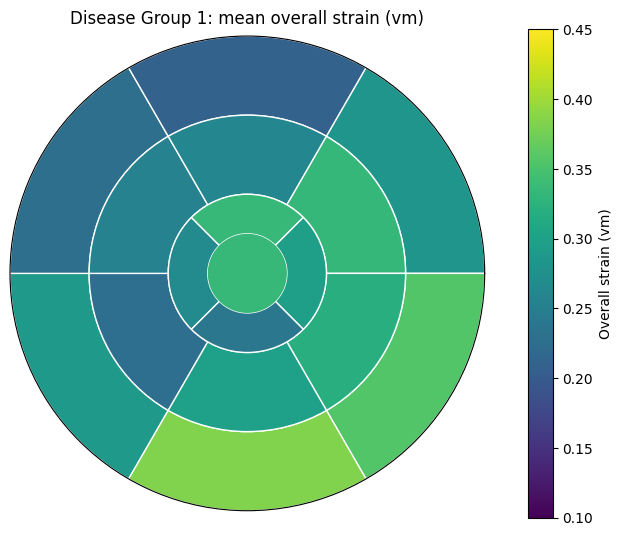

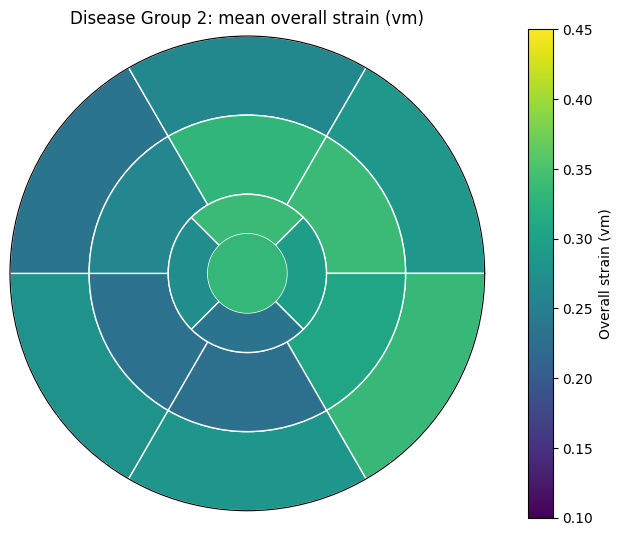

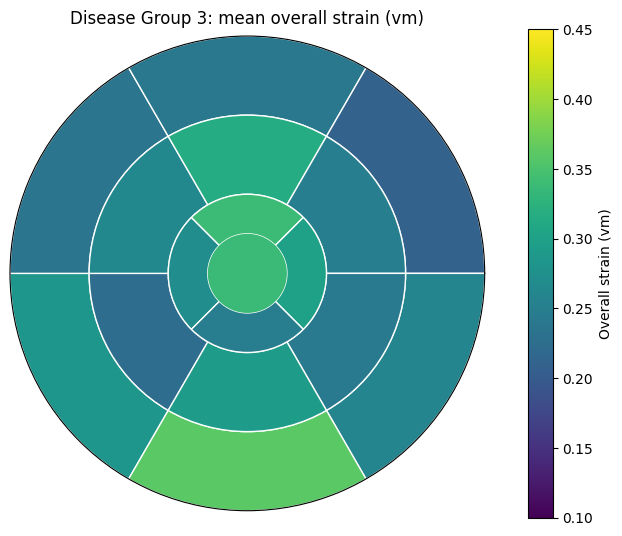

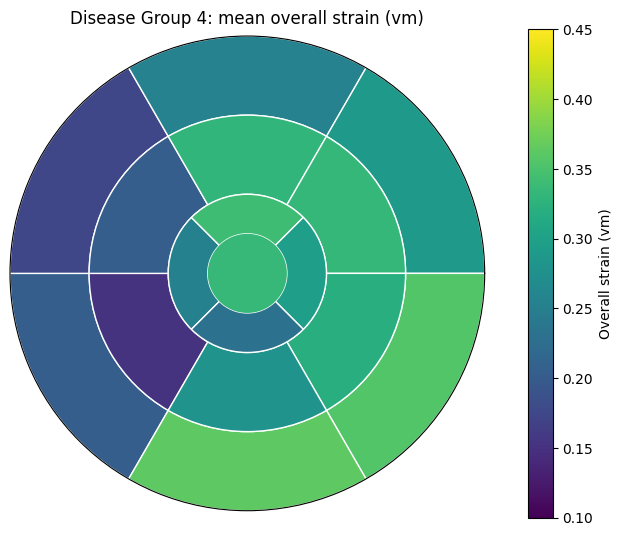

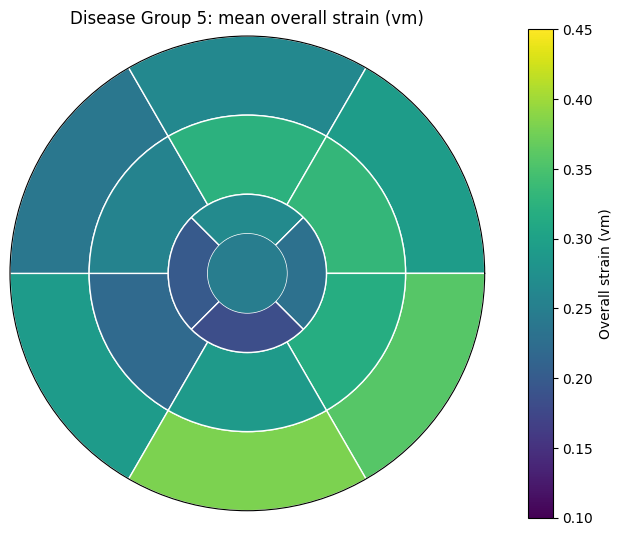

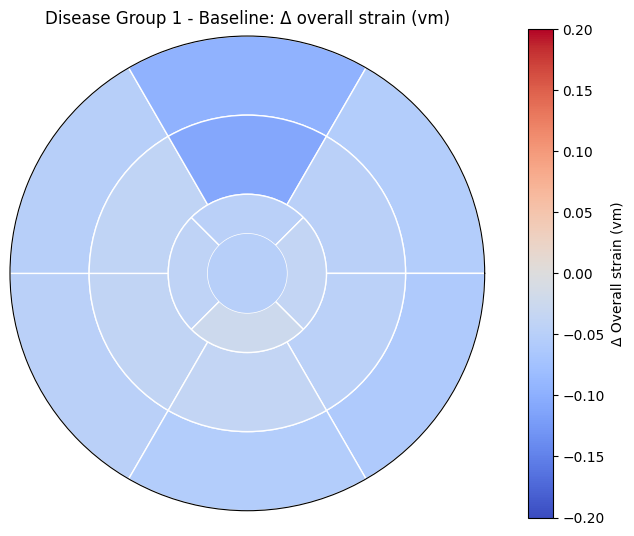

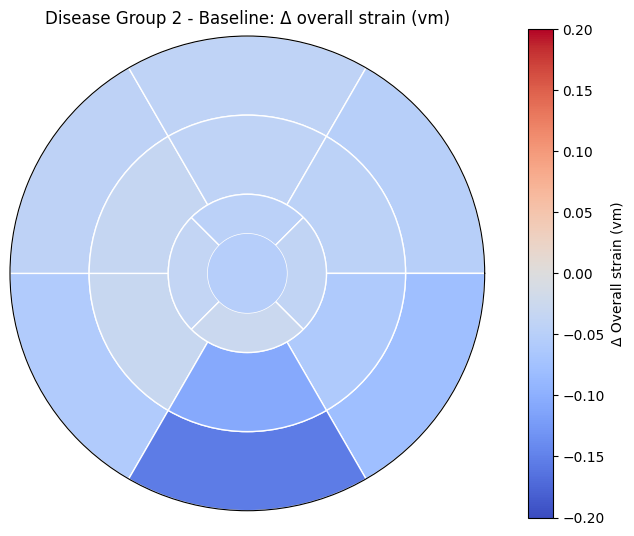

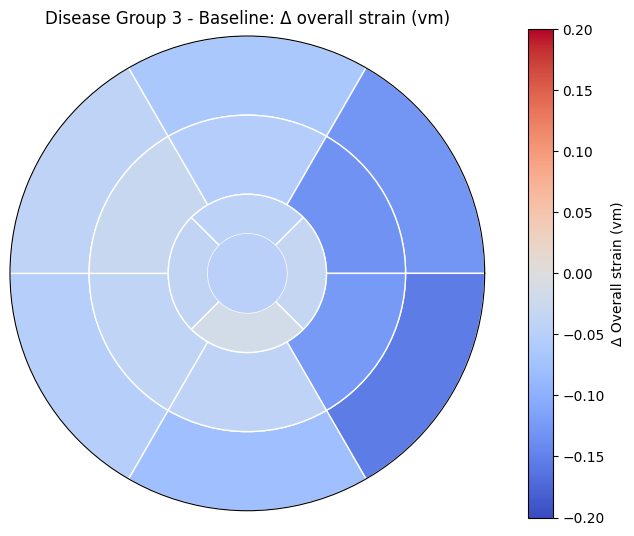

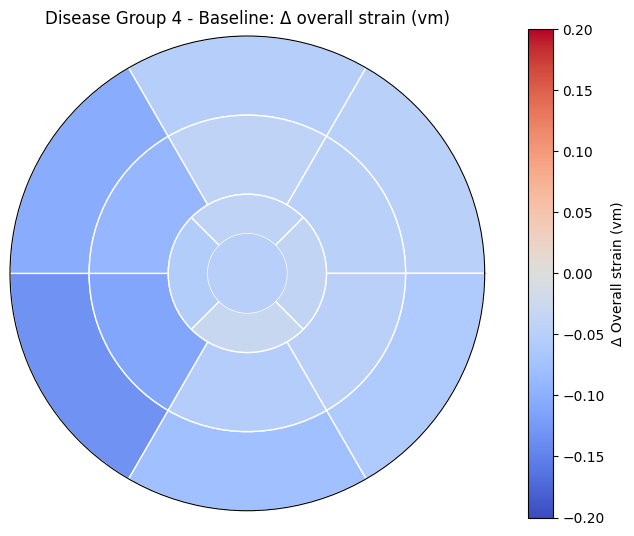

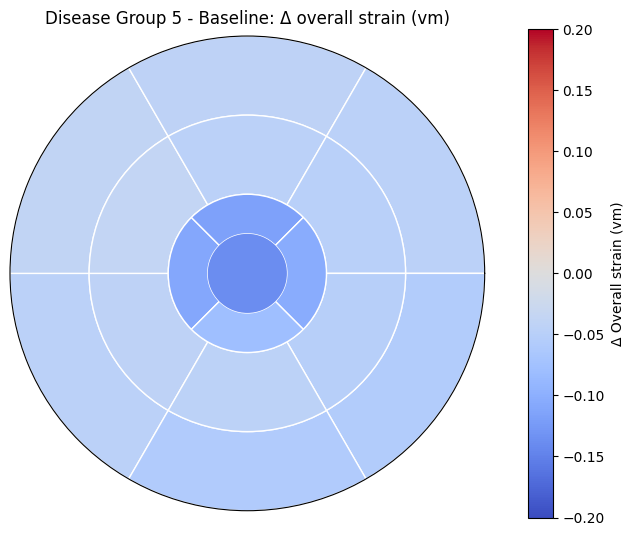

In [14]:
# ---------- Load ----------
baseline_path = "simulation_results_BL.txt"
disease_path  = "simulation_results_MI_2.txt"

df_bl, segs = load_strain_table(baseline_path)
df_mi, segs2 = load_strain_table(disease_path)
assert segs == segs2

# ---------- Compute overall(vm) ----------
bl_vm = compute_overall_vm_matrix(df_bl, segs)
mi_vm = compute_overall_vm_matrix(df_mi, segs)

baseline_ref = bl_vm.mean(axis=0)

# group disease rows: every 20 rows -> 5 groups (100 rows)
group_size = 20
group_ids = (np.arange(len(mi_vm)) // group_size).astype(int)
mi_vm_group = mi_vm.copy()
mi_vm_group["group"] = group_ids
group_means = mi_vm_group.groupby("group").mean(numeric_only=True)
delta_means = group_means.subtract(baseline_ref, axis="columns")

# ---------- Display tables ----------
summary = pd.DataFrame({"Baseline_mean(vm)": baseline_ref})
for g in group_means.index:
    summary[f"Group{g+1}_mean(vm)"]  = group_means.loc[g]
    summary[f"Group{g+1}_delta(vm)"] = delta_means.loc[g]


# ---------- Plot 5 group bullseyes ----------
abs_vmin, abs_vmax = float(group_means.min().min()), float(group_means.max().max())
for g in group_means.index:
    vals = group_means.loc[g].to_dict()
    plot_bullseye(
        vals,
        title=f"Disease Group {g+1}: mean overall strain (vm)",
        # vmin=abs_vmin, vmax=abs_vmax,
        vmin=0.1, vmax=0.45,
        show_labels=False
    )

# ---------- Plot 5 delta bullseyes (group - baseline) ----------
delta_vmin, delta_vmax = float(delta_means.min().min()), float(delta_means.max().max())
for g in delta_means.index:
    vals = delta_means.loc[g].to_dict()
    plot_bullseye(
        vals,
        title=f"Disease Group {g+1} - Baseline: Δ overall strain (vm)",
        # vmin=delta_vmin, vmax=delta_vmax,
        vmin=-0.2, vmax=0.2,
        symmetric_scale=True,
        show_labels=False,
        cmap="coolwarm"
    )


## MI_3

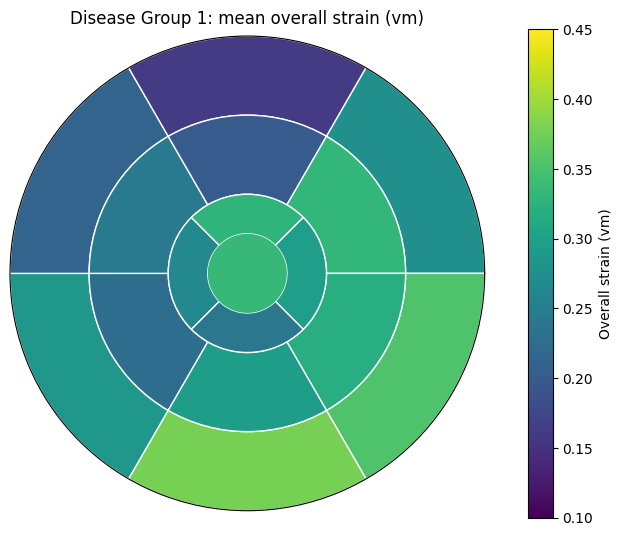

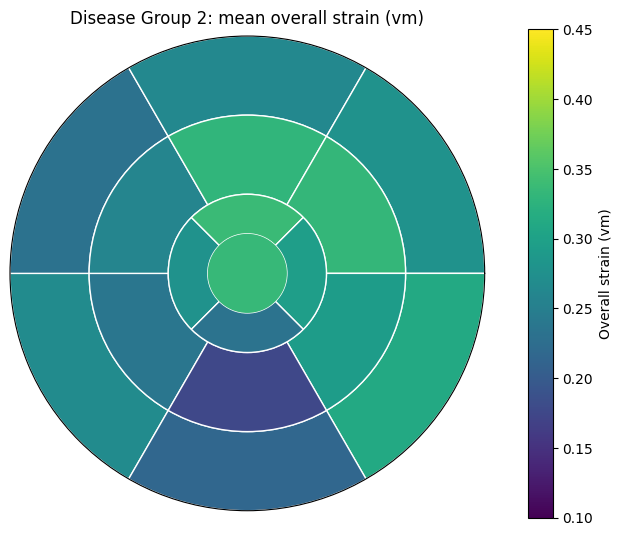

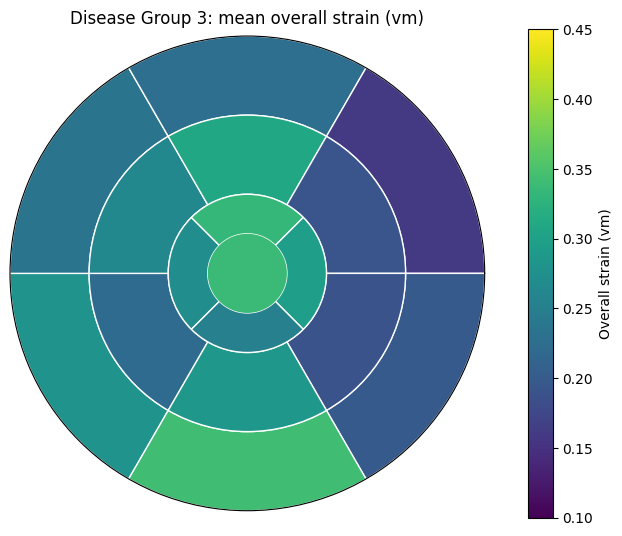

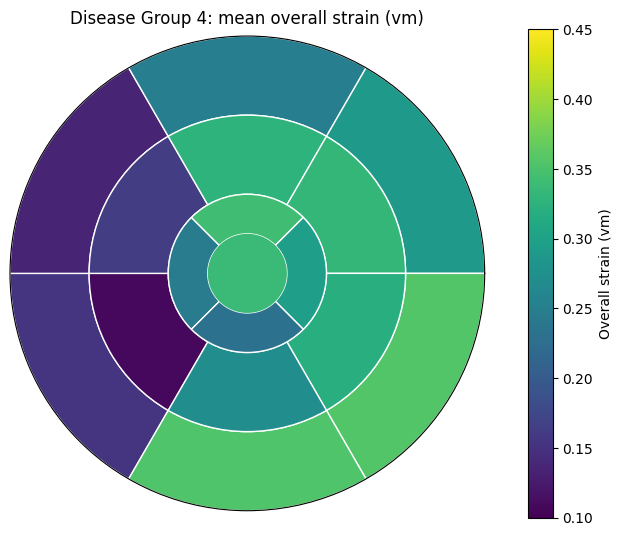

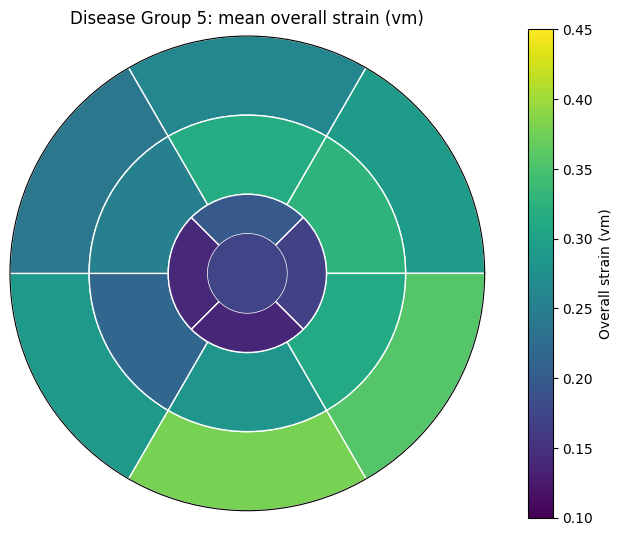

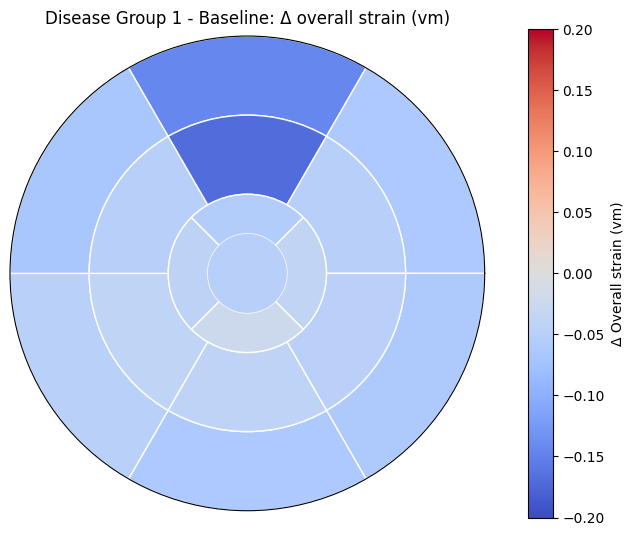

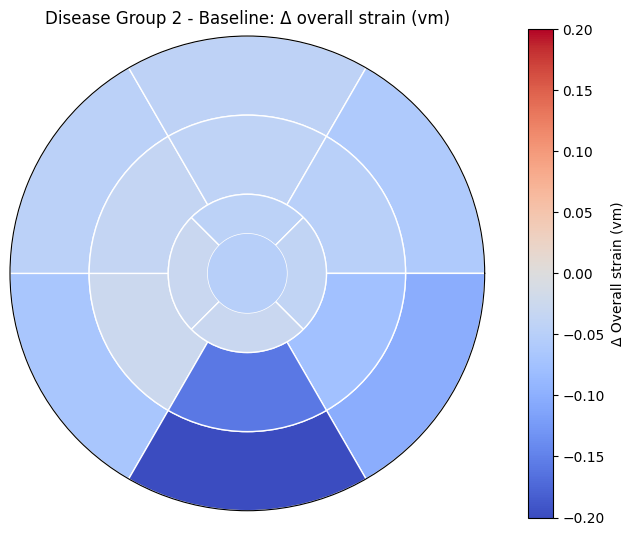

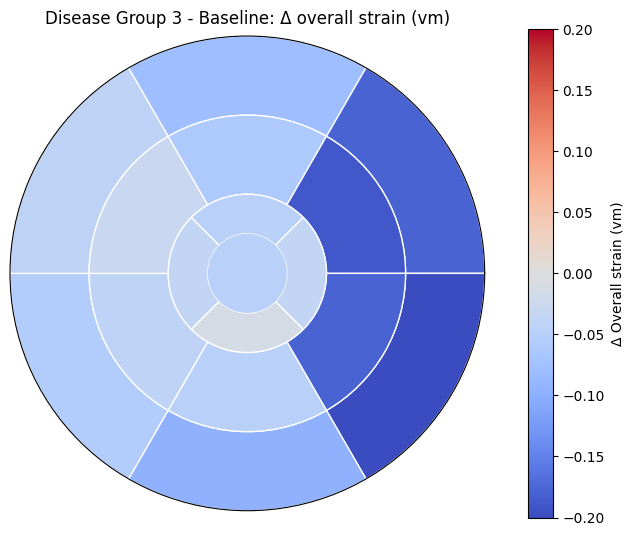

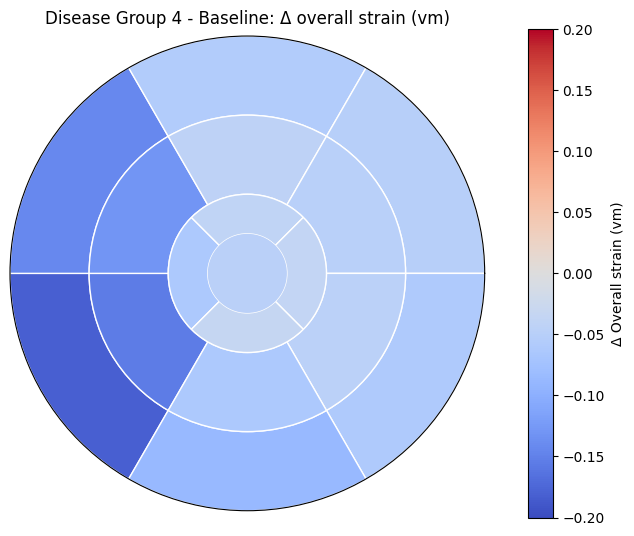

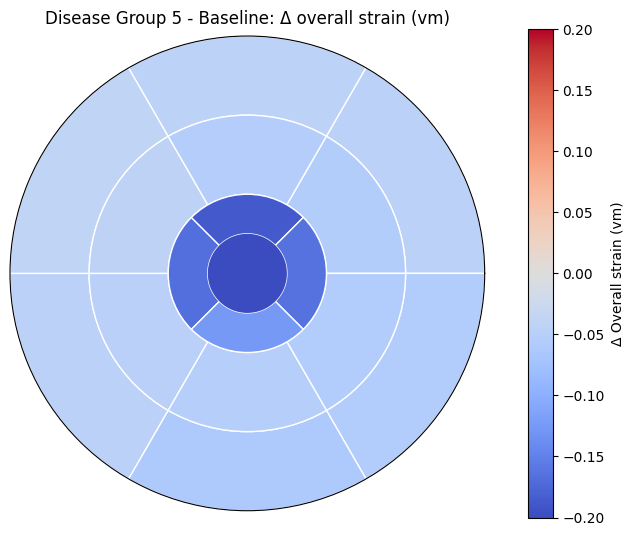

In [15]:
# ---------- Load ----------
baseline_path = "simulation_results_BL.txt"
disease_path  = "simulation_results_MI_3.txt"

df_bl, segs = load_strain_table(baseline_path)
df_mi, segs2 = load_strain_table(disease_path)
assert segs == segs2

# ---------- Compute overall(vm) ----------
bl_vm = compute_overall_vm_matrix(df_bl, segs)
mi_vm = compute_overall_vm_matrix(df_mi, segs)

baseline_ref = bl_vm.mean(axis=0)

# group disease rows: every 20 rows -> 5 groups (100 rows)
group_size = 20
group_ids = (np.arange(len(mi_vm)) // group_size).astype(int)
mi_vm_group = mi_vm.copy()
mi_vm_group["group"] = group_ids
group_means = mi_vm_group.groupby("group").mean(numeric_only=True)
delta_means = group_means.subtract(baseline_ref, axis="columns")

# ---------- Display tables ----------
summary = pd.DataFrame({"Baseline_mean(vm)": baseline_ref})
for g in group_means.index:
    summary[f"Group{g+1}_mean(vm)"]  = group_means.loc[g]
    summary[f"Group{g+1}_delta(vm)"] = delta_means.loc[g]


# ---------- Plot 5 group bullseyes ----------
abs_vmin, abs_vmax = float(group_means.min().min()), float(group_means.max().max())
for g in group_means.index:
    vals = group_means.loc[g].to_dict()
    plot_bullseye(
        vals,
        title=f"Disease Group {g+1}: mean overall strain (vm)",
        # vmin=abs_vmin, vmax=abs_vmax,
        vmin=0.1, vmax=0.45,
        show_labels=False
    )

# ---------- Plot 5 delta bullseyes (group - baseline) ----------
delta_vmin, delta_vmax = float(delta_means.min().min()), float(delta_means.max().max())
for g in delta_means.index:
    vals = delta_means.loc[g].to_dict()
    plot_bullseye(
        vals,
        title=f"Disease Group {g+1} - Baseline: Δ overall strain (vm)",
        # vmin=delta_vmin, vmax=delta_vmax,
        vmin=-0.2, vmax=0.2,
        symmetric_scale=True,
        show_labels=False,
        cmap="coolwarm"
    )


## HCM

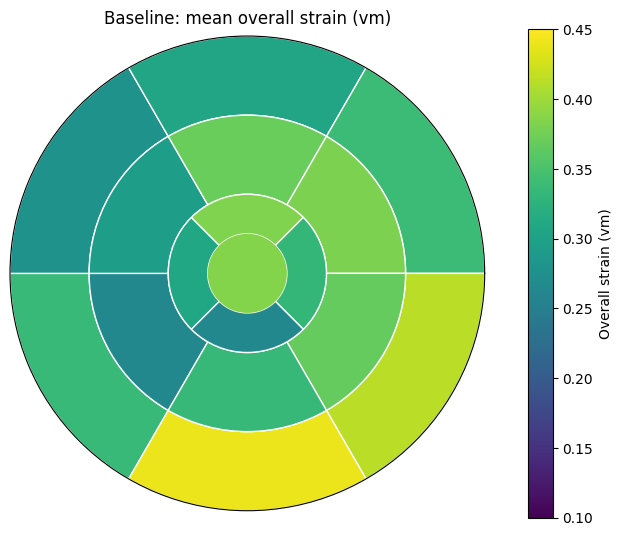

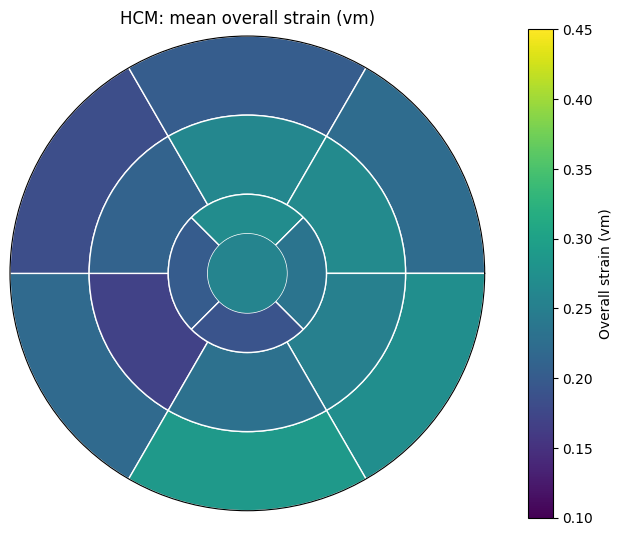

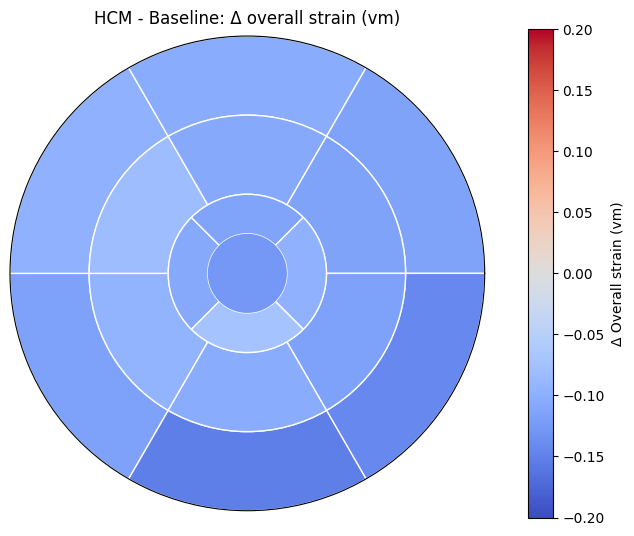

                 Baseline_mean_vm  HCM_mean_vm  Delta(HCM-BL)_vm
Basal-InfSept            0.336222     0.220016         -0.116206
Basal-AntSept            0.277990     0.182245         -0.095745
Basal-Ant                0.305755     0.201502         -0.104253
Basal-AntLat             0.337950     0.222453         -0.115497
Basal-InfLat             0.414280     0.271204         -0.143076
Basal-Inf                0.439757     0.288099         -0.151658
Mid-InfSept              0.262881     0.168994         -0.093887
Mid-AntSept              0.293184     0.210385         -0.082799
Mid-Ant                  0.370047     0.262574         -0.107473
Mid-AntLat               0.381302     0.266090         -0.115212
Mid-InfLat               0.367754     0.251426         -0.116328
Mid-Inf                  0.334263     0.229878         -0.104384
Apical-Septal            0.307840     0.201113         -0.106727
Apical-Anterior          0.382607     0.268840         -0.113767
Apical-Lateral           

In [18]:
SEGMENTS_16 = [
    "Basal-InfSept","Basal-AntSept","Basal-Ant","Basal-AntLat","Basal-InfLat","Basal-Inf",
    "Mid-InfSept","Mid-AntSept","Mid-Ant","Mid-AntLat","Mid-InfLat","Mid-Inf",
    "Apical-Septal","Apical-Anterior","Apical-Lateral","Apical-Inferior",
]
APEX = "Apex"


def load_strain_table(path: str):
    """
    Read whitespace-delimited txt without header.
    Expected columns:
      LV_volume + 3*(16 or 17 segments)
    Direction mapping (ASSUMED):
      dir1=circ, dir2=rad, dir3=longi
    """
    df_raw = pd.read_csv(path, sep=r"\s+", header=None)
    ncols = df_raw.shape[1]

    if ncols == 1 + 3*17:
        segs = SEGMENTS_16 + [APEX]
    elif ncols == 1 + 3*16:
        segs = SEGMENTS_16[:]
    else:
        raise ValueError(f"Unexpected ncols={ncols}. Expect 49 (no apex) or 52 (with apex).")

    cols = ["LV_volume"]
    for d in range(1, 4):
        cols += [f"{seg}__dir{d}" for seg in segs]
    df_raw.columns = cols

    # If no apex in file, add NaN apex columns for uniform plotting logic
    if APEX not in segs:
        for d in range(1, 4):
            df_raw[f"{APEX}__dir{d}"] = np.nan
        segs = segs + [APEX]

    return df_raw, segs


def overall_vm(ecc, err, ell):
    """
    Von Mises equivalent strain (nonnegative).
    """
    em = (ecc + err + ell) / 3.0
    return np.sqrt((2.0/3.0) * ((ecc-em)**2 + (err-em)**2 + (ell-em)**2))


def compute_overall_vm_matrix(df: pd.DataFrame, segments):
    """
    Return a dataframe (n_rows x n_segments) with overall_vm per segment.
    """
    out = {}
    for seg in segments:
        ecc = df[f"{seg}__dir1"].to_numpy(dtype=float)  # circ
        err = df[f"{seg}__dir2"].to_numpy(dtype=float)  # rad
        ell = df[f"{seg}__dir3"].to_numpy(dtype=float)  # longi
        out[seg] = overall_vm(ecc, err, ell)
    return pd.DataFrame(out, index=df.index)


def plot_bullseye(values_by_name,
                  title="",
                  basal_mid_start_deg=240.0,
                  apical_start_deg=225.0,
                  vmin=None, vmax=None,
                  symmetric_scale=False,
                  show_labels=False,
                  show_apex_label=False,
                  cmap="viridis"):
    """
    Bullseye:
      - Basal (6) : starts at 240° and goes clockwise
      - Mid   (6) : starts at 240° and goes clockwise
      - Apical(4) : starts at 225° and goes clockwise
      - Apex (1)  : filled disk, NO split lines
    """
    basal_order  = ["Basal-InfSept","Basal-AntSept","Basal-Ant","Basal-AntLat","Basal-InfLat","Basal-Inf"]
    mid_order    = ["Mid-InfSept","Mid-AntSept","Mid-Ant","Mid-AntLat","Mid-InfLat","Mid-Inf"]
    apical_order = ["Apical-Septal","Apical-Anterior","Apical-Lateral","Apical-Inferior"]

    rings = [
        ("Basal",  basal_order,  (2.0, 1.0), 60.0, basal_mid_start_deg),
        ("Mid",    mid_order,    (1.0, 1.0), 60.0, basal_mid_start_deg),
        ("Apical", apical_order, (0.5, 0.5), 90.0, apical_start_deg),
        ("Apex",   [APEX],       (0.0, 0.5), 360.0, 0.0),
    ]

    finite_vals = np.array([v for v in values_by_name.values() if np.isfinite(v)], dtype=float)
    if finite_vals.size == 0:
        raise ValueError("No finite values to plot.")
    if vmin is None: vmin = float(np.min(finite_vals))
    if vmax is None: vmax = float(np.max(finite_vals))
    if symmetric_scale:
        m = max(abs(vmin), abs(vmax))
        vmin, vmax = -m, m
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, projection="polar")
    ax.set_theta_direction(-1)   # clockwise
    ax.set_theta_offset(0.0)     # 0° at 3 o'clock
    ax.set_ylim(0, 3.0)
    ax.set_xticks([]); ax.set_yticks([]); ax.grid(False)

    for ring_name, seg_names, (bottom, thickness), width_deg, start_deg in rings:
        if ring_name == "Apex":
            val = values_by_name.get(APEX, np.nan)
            if np.isfinite(val):
                ax.bar(
                    np.deg2rad(0.0), thickness, width=2*np.pi, bottom=bottom, align="edge",
                    linewidth=0.0, edgecolor="none",  # <- no split lines in apex
                    color=plt.get_cmap(cmap)(norm(val))
                )
                if show_apex_label and show_labels:
                    ax.text(0, bottom + thickness/2, "Apex", ha="center", va="center", fontsize=9)
            continue

        width = np.deg2rad(width_deg)
        for i, nm in enumerate(seg_names):
            val = values_by_name.get(nm, np.nan)
            if not np.isfinite(val):
                continue

            seg_start_deg = start_deg - i * width_deg
            theta0 = np.deg2rad(-seg_start_deg)  # negative so displayed degrees match your convention

            ax.bar(
                theta0, thickness, width=width, bottom=bottom, align="edge",
                linewidth=1.0, edgecolor="white",
                color=plt.get_cmap(cmap)(norm(val))
            )

            if show_labels:
                theta_mid = theta0 + width/2
                r_mid = bottom + thickness/2
                short = (nm.replace("Basal-", "B ")
                           .replace("Mid-", "M ")
                           .replace("Apical-", "A "))
                ax.text(theta_mid, r_mid, short, ha="center", va="center", fontsize=9)

    ax.set_title(title, va="bottom", fontsize=12)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.08, fraction=0.045)
    cbar.set_label("Overall strain (vm)" if not symmetric_scale else "Δ Overall strain (vm)")
    plt.show()


def main():

    baseline_path = "simulation_results_BL.txt"
    hcm_path      = "simulation_results_HCM.txt"

    show_labels = False  # <- True/False

    # ---- Load ----
    df_bl, segs = load_strain_table(baseline_path)
    df_hcm, segs2 = load_strain_table(hcm_path)
    assert segs == segs2, "Baseline and HCM segments mismatch."

    # ---- overall(vm) per row per segment ----
    bl_vm  = compute_overall_vm_matrix(df_bl, segs)
    hcm_vm = compute_overall_vm_matrix(df_hcm, segs)

    # 基线与HCM：对各自所有行取均值（基线若只有1行也没问题）
    bl_mean  = bl_vm.mean(axis=0)
    hcm_mean = hcm_vm.mean(axis=0)

    # 差异：HCM - Baseline
    delta = hcm_mean - bl_mean

    # 统一色条（方便对比）
    abs_vmin = float(min(bl_mean.min(), hcm_mean.min()))
    abs_vmax = float(max(bl_mean.max(), hcm_mean.max()))
    dmin = float(delta.min())
    dmax = float(delta.max())
    dm = max(abs(dmin), abs(dmax))

    # ---- Plot baseline / HCM / delta ----
    plot_bullseye(
        bl_mean.to_dict(),
        title="Baseline: mean overall strain (vm)",
        # vmin=abs_vmin, vmax=abs_vmax,
        vmin=0.1, vmax=0.45,
        show_labels=show_labels,
        cmap="viridis"
    )

    plot_bullseye(
        hcm_mean.to_dict(),
        title="HCM: mean overall strain (vm)",
        # vmin=abs_vmin, vmax=abs_vmax,
        vmin=0.1, vmax=0.45,
        show_labels=show_labels,
        cmap="viridis"
    )

    plot_bullseye(
        delta.to_dict(),
        title="HCM - Baseline: Δ overall strain (vm)",
        # vmin=-dm, vmax=dm,
        vmin=-0.2, vmax=0.2,
        symmetric_scale=True,
        show_labels=show_labels,
        # cmap="Blues_r"
        cmap="coolwarm"
    )

    # ---- Optional: 输出每个区域的数值表 ----
    summary = pd.DataFrame({
        "Baseline_mean_vm": bl_mean,
        "HCM_mean_vm": hcm_mean,
        "Delta(HCM-BL)_vm": delta
    })
    print(summary)


if __name__ == "__main__":
    main()


# End